In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# 폰트 관리자
import matplotlib.font_manager as fm
font_name=fm.FontProperties(fname="C:\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font",family=font_name)

# 음수 표현
import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"]=False

In [2]:
charging_data = pd.read_csv("data/한국전력공사_전기차 충전소 충전량_20220330.csv")

# 충전용량 50, 7 외 삭제
charging_data = charging_data[(charging_data["충전용량"] == 50.0)|(charging_data["충전용량"] == 7.0)]


# 충전분 -> 시간 변환 = 총충전시간
charging_data["충전시간"]=round(charging_data["충전시간"]+charging_data["충전분"]/60,2)

#사용칼럼만 남기고 칼럼 삭제
charging_data = charging_data[["충전소명","충전기ID", "주소","충전기구분","충전용량","충전량","충전시작시각", "충전종료시각","충전시간"]]

# 충전량 80이하만 
charging_data = charging_data[charging_data["충전량"] <= 80.0]

# 주소 null값 삭제
# charging_data["주소"].replace(" ",np.nan, inplace=True)
charging_data = charging_data[charging_data["주소"].notnull()]
charging_data = charging_data[~charging_data["주소"].str.contains("null", na=False, case=False)]

# 총 충전시간 5분이하 24시간 이상 삭제
charging_data = charging_data[(charging_data["충전시간"] >= 0.08) & (charging_data["충전시간"] <= 24.0)]

# 주소지 제주도 행 삭제 
charging_data = charging_data[~charging_data['주소'].str.contains("제주", na=False, case=False)]

# 실충전시간 = 충전량/충전용량
charging_data["실충전시간"] = charging_data["충전량"]/charging_data["충전용량"]

# 미사용시간 = 충전시간-실충전시간
charging_data["미사용시간"] = charging_data["충전시간"]-charging_data["실충전시간"]


C:\Users\user\AppData\Local\Temp\ipykernel_12492\3926086171.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  charging_data = pd.read_csv("data/한국전력공사_전기차 충전소 충전량_20220330.csv")


In [35]:
charging_data

,충전소명,충전기ID,주소,충전기구분,충전용량,충전량,충전시작시각,충전종료시각,충전시간,실충전시간,미사용시간,시구분
0,국민체육센터,USCE20040701,울산광역시 남구 야음동 184-1,급속,50.0,17.72,2022-01-01 9:51,2022-01-01 10:31,0.67,0.354400,0.315600,울산광역시
1,국민체육센터,USCE20040701,울산광역시 남구 야음동 184-1,급속,50.0,11.96,2022-01-01 10:33,2022-01-01 11:13,0.67,0.239200,0.430800,울산광역시
2,동두천지사,876,경기도 동두천시 평화로 2262,급속,50.0,8.83,2022-01-01 18:38,2022-01-01 18:59,0.35,0.176600,0.173400,경기도
3,동두천지사,876,경기도 동두천시 평화로 2262,급속,50.0,50.00,2022-01-01 19:10,2022-01-01 21:05,1.92,1.000000,0.920000,경기도
4,동두천지사,876,경기도 동두천시 평화로 2262,급속,50.0,43.01,2022-01-01 12:37,2022-01-01 13:35,0.95,0.860200,0.089800,경기도
...,...,...,...,...,...,...,...,...,...,...,...,...
813732,더샵스타시티 아파트,1921,서울특별시 광진구 자양동 아차산로 262,완속,7.0,5.11,2022-03-30 20:44,2022-03-30 22:15,1.50,0.730000,0.770000,서울특별시
813733,공지천 공영주차장,5928,강원도 춘천시 영서로 2438,급속,50.0,37.64,2022-03-30 21:15,2022-03-30 22:15,1.00,0.752800,0.247200,강원도
813734,가재마을3단지,4499,세종특별자치시 도움3로 159,완속,7.0,33.12,2022-03-30 17:03,2022-03-30 22:25,5.35,4.731429,0.618571,세종특별자치시
813735,강원도개발공사,9433,강원도 춘천시 외솔길 17,급속,50.0,40.42,2022-03-30 15:19,2022-03-30 16:19,1.00,0.808400,0.191600,강원도


In [5]:
# 전처리 완료 파일 저장
charging_data.to_csv("data/teamwork/Pre_Charging.csv", encoding="utf-8", index=False)

In [7]:
charging_data = pd.read_csv("data/teamwork/Pre_Charging.csv")
# charging_data자료중 "시"구분
add = charging_data["주소"].str.split(" ")
charging_data["시구분"]=[i[0] for i in add ]
charging_data.head()

# 시별 충전량, 충전시간, 미사용시간 df 만들기
data = charging_data.groupby("시구분")[["충전량","충전시간","미사용시간"]].mean().round(2)

# 시별 측정 수량 컬럼 추가
data["총충전횟수"] = charging_data.groupby("시구분")[["시구분"]].count()

# 데이터수량, 미사용시간 산점도 그려보기(sum 자료는 비례방향뚜렷)
# plt.plot(data["데이터수량"],data["미사용시간"], 'o')

# 데이터 수량 순위 행 추가
data["충전횟수순위"]= data["총충전횟수"].rank()

# 시별 전기차 충전소 수 확인
ev_data = pd.read_csv("data/전기차충전소_220329.csv")
ev_data.head()

ev_add = ev_data["RN_ADRES"].str.split(" ")
ev_data["시구분"]=[i[0] for i in ev_add ]

data["충전소수"]=ev_data.groupby("시구분")[["시구분"]].count()

# 시별 전기차 등록대수 행 추가
ev_car = pd.read_csv("data/한국전력공사_지역별 전기차 현황정보_20220429.csv")
ev_car = ev_car[ev_car.columns[1:-2]]
ev_car = ev_car.rename(columns={"서울":"서울특별시","인천":"인천광역시",
                               "경기":"경기도","강원":"강원도",
                               "충북":"충청북도","충남":"충청남도",
                               "대전":"대전광역시","세종":"세종특별자치시",
                               "경북":"경상북도","대구":"대구광역시",
                               "전북":"전라북도","전남":"전라남도",
                               "광주":"광주광역시","경남":"경상남도",
                               "부산":"부산광역시", "울산":"울산광역시"})
ev_car=ev_car.loc[[0]]
ev_car=ev_car.T
data["전기차등록대수"]=ev_car[0]

data
data.to_csv("data/teamwork/Si_consolidation.csv", encoding="utf-8")

C:\Users\user\AppData\Local\Temp\ipykernel_15660\1724847631.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  charging_data = pd.read_csv("data/teamwork/Pre_Charging.csv")


### 시별 인구수, 전기차 등록대수, 전기차 충전소 행 추가

In [20]:
# 시별 전기차 충전소 수 확인
ev_data = pd.read_csv("data/전기차충전소_220329.csv")
ev_data.head()

ev_add = ev_data["RN_ADRES"].str.split(" ")
ev_data["시구분"]=[i[0] for i in ev_add ]
ev_data.head()

data["충전소수"]=ev_data.groupby("시구분")[["시구분"]].count()
data

,충전량,충전시간,미사용시간,총충전횟수,충전횟수순위,충전소수
시구분,,,,,,
강원도,26.92,1.94,0.53,42571,11.0,3377
경기도,24.64,3.16,1.04,186966,16.0,23717
경상남도,26.05,2.39,0.77,52588,12.0,5707
경상북도,26.92,2.37,0.95,40389,10.0,5921
광주광역시,27.49,2.65,0.73,17907,3.0,3176
대구광역시,27.01,3.20,1.16,58638,14.0,6170
대전광역시,27.22,2.68,0.73,35752,7.0,2670
부산광역시,25.06,2.21,0.77,36862,9.0,5224
서울특별시,24.25,2.58,0.86,137278,15.0,17076


In [33]:
# 시별 전기차 등록대수 행 추가
ev_car = pd.read_csv("data/한국전력공사_지역별 전기차 현황정보_20220429.csv")
ev_car = ev_car[ev_car.columns[1:-2]]
ev_car = ev_car.rename(columns={"서울":"서울특별시","인천":"인천광역시",
                               "경기":"경기도","강원":"강원도",
                               "충북":"충청북도","충남":"충청남도",
                               "대전":"대전광역시","세종":"세종특별자치시",
                               "경북":"경상북도","대구":"대구광역시",
                               "전북":"전라북도","전남":"전라남도",
                               "광주":"광주광역시","경남":"경상남도",
                               "부산":"부산광역시", "울산":"울산광역시"})
ev_car=ev_car.loc[[0]]
ev_car=ev_car.T
data["전기차등록대수"]=ev_car[0]
data

,충전량,충전시간,미사용시간,총충전횟수,충전횟수순위,충전소수,전기차등록대수
시구분,,,,,,,
강원도,26.92,1.94,0.53,42571,11.0,3377,8652
경기도,24.64,3.16,1.04,186966,16.0,23717,45891
경상남도,26.05,2.39,0.77,52588,12.0,5707,14371
경상북도,26.92,2.37,0.95,40389,10.0,5921,12318
광주광역시,27.49,2.65,0.73,17907,3.0,3176,6015
대구광역시,27.01,3.20,1.16,58638,14.0,6170,17584
대전광역시,27.22,2.68,0.73,35752,7.0,2670,8595
부산광역시,25.06,2.21,0.77,36862,9.0,5224,15330
서울특별시,24.25,2.58,0.86,137278,15.0,17076,43206


### data 자료로 그래프 그리기

In [15]:
data=pd.read_csv("data/teamwork/Si_consolidation.csv",index_col=0)
data

,충전량,충전시간,미사용시간,총충전횟수,충전횟수순위,충전소수,전기차등록대수
시구분,,,,,,,
강원도,26.92,1.94,0.53,42571,11.0,3377,8652
경기도,24.64,3.16,1.04,186966,16.0,23717,45891
경상남도,26.05,2.39,0.77,52588,12.0,5707,14371
경상북도,26.92,2.37,0.95,40389,10.0,5921,12318
광주광역시,27.49,2.65,0.73,17907,3.0,3176,6015
대구광역시,27.01,3.20,1.16,58638,14.0,6170,17584
대전광역시,27.22,2.68,0.73,35752,7.0,2670,8595
부산광역시,25.06,2.21,0.77,36862,9.0,5224,15330
서울특별시,24.25,2.58,0.86,137278,15.0,17076,43206


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


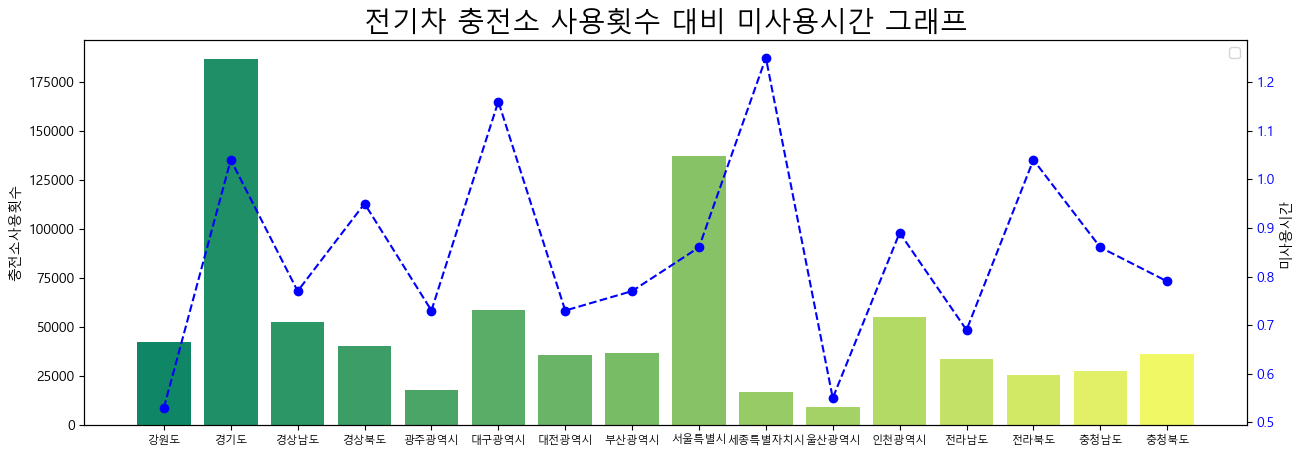

In [74]:
fig=plt.figure(figsize=(15,5))
fig.set_facecolor("white")
ax1 = fig.add_subplot() ## axes 생성

xtick_label_position = list(range(len(data.index))) ## x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) ## x축 눈금 
ax1.set_xticklabels(data.index, fontsize=8) ## x축 눈금 라벨
ax1.bar(xtick_label_position, data["총충전횟수"], color=colors) ## 바차트 출력
ax1.set_ylabel("충전소사용횟수")

ax2 = ax1.twinx() ## 새로운 axis 생성
ax2.plot(xtick_label_position, data["미사용시간"], color="blue", linestyle='--', marker='o') ## 선 그래프 
ax2.tick_params(axis='y', labelcolor="blue") ## 눈금 라벨 색상 지정
ax2.set_ylabel("미사용시간")

plt.title('전기차 충전소 사용횟수 대비 미사용시간 그래프', fontsize=20)
plt.legend()
plt.show()



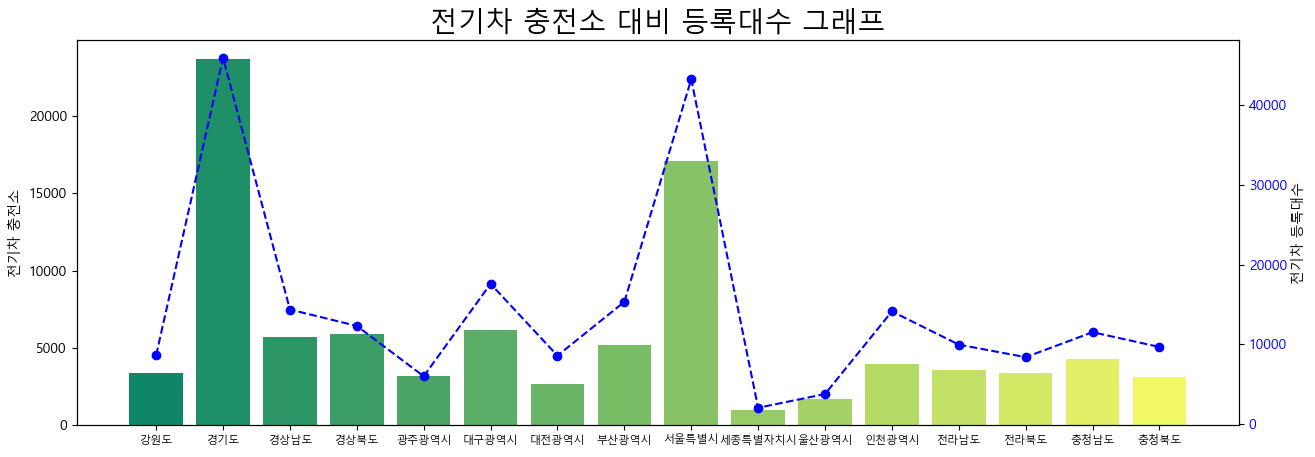

In [73]:
fig=plt.figure(figsize=(15,5))
fig.set_facecolor("white")
ax1 = fig.add_subplot() ## axes 생성

xtick_label_position = list(range(len(data.index))) ## x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) ## x축 눈금 
ax1.set_xticklabels(data.index, fontsize=8) ## x축 눈금 라벨
ax1.bar(xtick_label_position, data["충전소수"], color=colors) ## 바차트 출력
ax1.set_ylabel("전기차 충전소")

ax2 = ax1.twinx() ## 새로운 axis 생성
ax2.plot(xtick_label_position, data["전기차등록대수"], color="blue", linestyle='--', marker='o') ## 선 그래프 
ax2.tick_params(axis='y', labelcolor="blue") ## 눈금 라벨 색상 지정
ax2.set_ylabel("전기차 등록대수")

plt.title('전기차 충전소 대비 등록대수 그래프', fontsize=20)
plt.show()

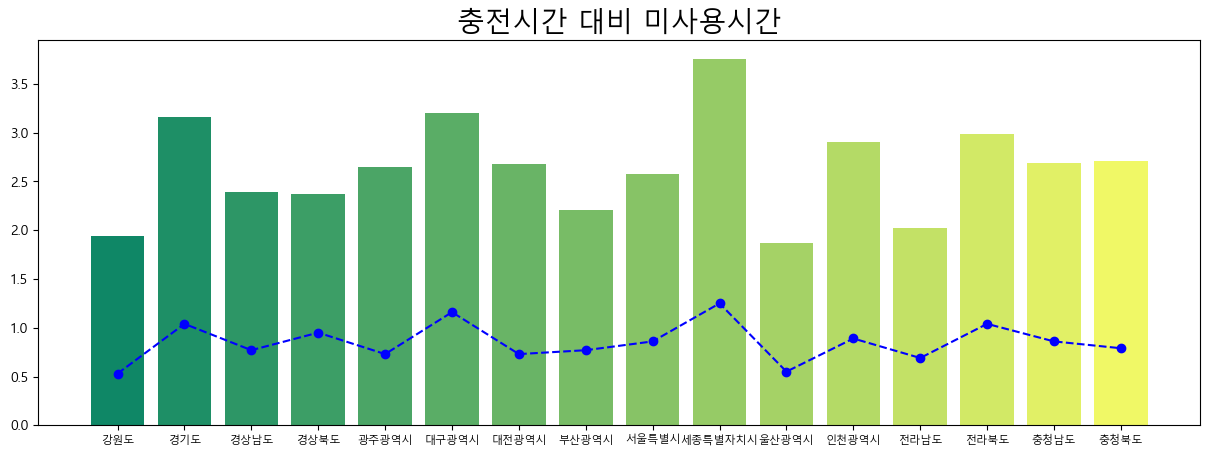

In [66]:
fig = plt.figure(figsize=(15,5)) ## Figure 생성 
fig.set_facecolor('white') ## Figure 배경색 지정
 
xtick_label_position = list(range(len(data.index))) ## x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position, data.index, fontsize=8) ## x축 눈금 라벨 출력
 
plt.bar(xtick_label_position, data["충전시간"], color=colors) ## 바차트 출력
plt.plot(xtick_label_position, data["미사용시간"], color='b',
         linestyle='--', marker='o') ## 선 그래프 출력
plt.title('충전시간 대비 미사용시간', fontsize=20)
plt.show()